# Introduction

In [34]:
import math
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from torchsummary import summary

import random


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

import torch
import torch.nn as nn

import torchvision.transforms as T
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
from PIL import Image
        
import torch
import torch.nn.functional as F
import torch.optim as optim
import torchvision


preprocessing_seed = 6
seed = 6
CUDA_LAUNCH_BLOCKING=1 
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [35]:
df = pd.read_csv('fer2013.csv')
df.head()    
df.emotion.unique()

array([0, 2, 4, 6, 3, 5, 1])

In [36]:
df["goal"] = np.where(df["Usage"]=="Training", "train", np.where(df["Usage"]=="PublicTest", "test", "validation"))

emotion_label_to_text = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}


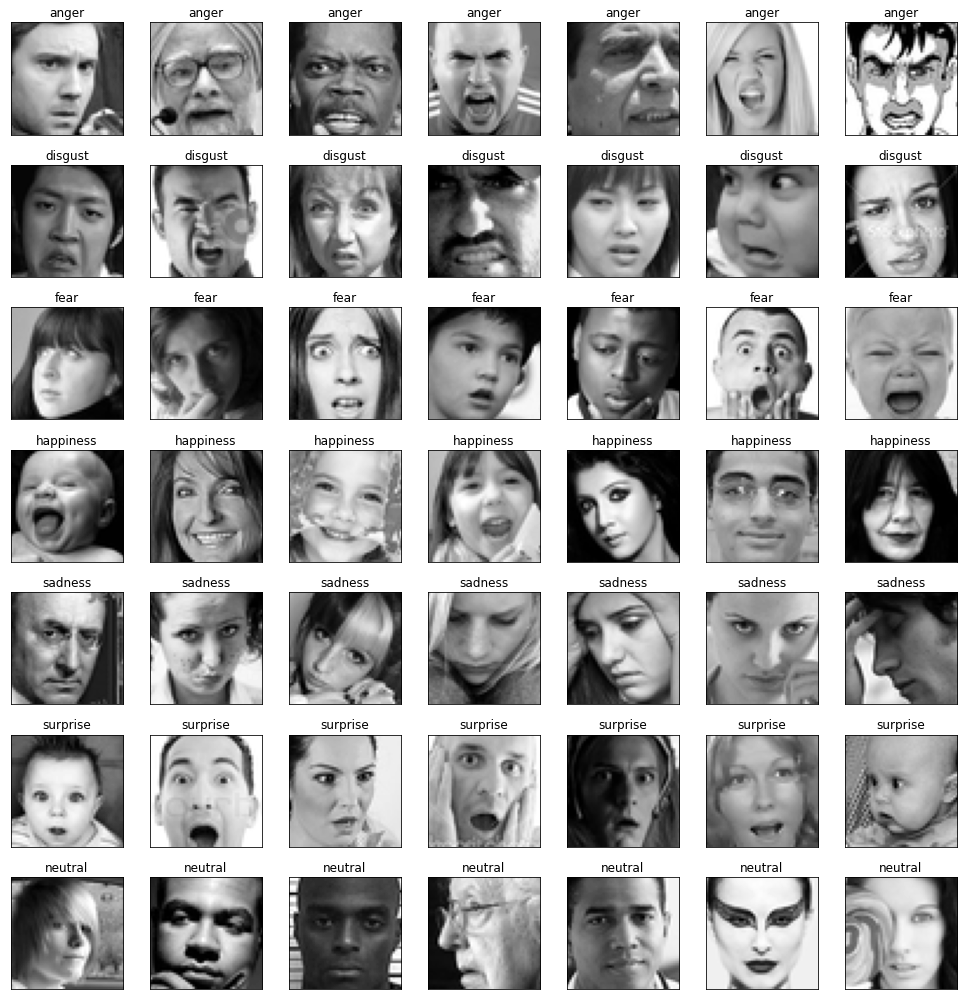

In [37]:
def plot_images(df):
    fig = plt.figure(1, (14, 14))
    k = 0
    for label in sorted(df.emotion.unique()):
        for j in range(7):
            px = df[df.emotion==label].pixels.iloc[k]
            px = np.array(px.split(' ')).reshape(48, 48).astype('float32')
            k += 1
            ax = plt.subplot(7, 7, k)
            ax.imshow(px, cmap='gray')
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_title(emotion_label_to_text[label])
            plt.tight_layout()
    return

plot_images(df)

# Datasets

In [38]:
class EmotionDataset(Dataset):
  def __init__(self, df, split="train", transforms=T.Compose([])):
    self.df = df.loc[df["goal"]==split].reset_index()
    self.transforms = transforms
  def __len__(self):
    return len(self.df)

  def __getitem__(self, i):
    item = self.df.loc[i]
    image = np.array(item['pixels'].split(' ')).reshape(48, 48).astype('float32') # Reshaping shapeless pixels
    class_idx = torch.tensor(item['emotion'])
    img = Image.fromarray(image).convert("RGB")
    img = self.transforms(img)
    return img, class_idx

transforms = T.Compose([
        T.ToTensor(),
        torchvision.transforms.RandomHorizontalFlip(0.5),
        T.Normalize(0.5, 0.5)
    ])


# Data Loaders

In [39]:
train_dset = EmotionDataset(df, split="train", transforms=transforms)
val_dset = EmotionDataset(df, split="validation", transforms=transforms)
test_dset = EmotionDataset(df, split="test", transforms=transforms)

train_loader = DataLoader(train_dset, batch_size=64, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dset, batch_size=64, shuffle=False, drop_last=False)
test_loader = DataLoader(test_dset, batch_size=64, shuffle=False, drop_last=False)

loaders = {"train": train_loader,
           "validation": val_loader,
           "test": test_loader}

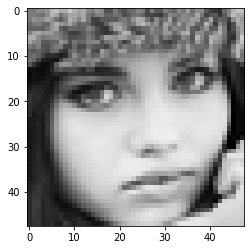

In [40]:
train_dset_plot = EmotionDataset(df, split="train")
img, label = train_dset_plot[1110]
plt.imshow(img)

# Train Function

In [41]:
def train(net, loaders, optimizer, criterion, epochs=15, device=torch.device('cpu')):
    try:
        results = {}
        models = {}
        net = net.to(device)
        history_loss = {"train": [], "validation":[], "test": []}
        history_accuracy = {"train": [], "validation":[],  "test": []}
        # Process each epoch
        for epoch in range(epochs):
            print(f"Running epoch: {epoch+1}")
            # Initialize epoch variables
            sum_loss = {"train": 0,"validation":0,  "test": 0}
            sum_accuracy = {"train": 0, "validation":0, "test": 0}
            # Process each split
            for split in ["train", "validation", "test"]:
                if split == "train":
                  net.train()
                else:
                  net.eval()
                # Process each batch
                for (input, labels) in loaders[split]:
                    # Move to CUDA
                    input = input.to(device)
                    labels = labels.to(device)
                    # Reset gradients
                    optimizer.zero_grad()
                    # Compute output
                    pred = net(input)
                    loss = criterion(pred, labels)
                    # Update loss
                    sum_loss[split] += loss.item()
                    # Check parameter update
                    if split == "train":
                        # Compute gradients
                        loss.backward()
                        # Optimize
                        optimizer.step()
                    # Compute accuracy
                    _,pred_labels = pred.max(1)
                    batch_accuracy = (pred_labels == labels).sum().item()/input.size(0)
                    # Update accuracy
                    sum_accuracy[split] += batch_accuracy
            # Compute epoch loss/accuracy
            epoch_loss = {split: sum_loss[split]/len(loaders[split]) for split in ["train","validation", "test"]}
            epoch_accuracy = {split: sum_accuracy[split]/len(loaders[split]) for split in ["train", "validation", "test"]}
            # Update history
            for split in ["train", "validation", "test"]:
                history_loss[split].append(epoch_loss[split])
                history_accuracy[split].append(epoch_accuracy[split])
            # Print info
            models[epoch+1] = net
            results[epoch+1] = {"train_loss":epoch_loss['train'],
                                "train_accuracy":epoch_accuracy['train'],
                                "validation_loss":epoch_loss['validation'],
                                "validation_accuracy":epoch_accuracy['validation'],
                                "test_loss":epoch_loss['test'],
                                "test_accuracy":epoch_accuracy['test']}
            print(f"Epoch {epoch+1}:",
                  f"TrL={epoch_loss['train']:.4f},",
                  f"TrA={epoch_accuracy['train']:.4f},",
                  f"VaL={epoch_loss['validation']:.4f},",
                  f"VaA={epoch_accuracy['validation']:.4f},",
                  f"TeL={epoch_loss['test']:.4f},",
                  f"TeA={epoch_accuracy['test']:.4f},")
    except KeyboardInterrupt:
        print("Interrupted")
    except RuntimeError as e:
      print(e)
    except ValueError as e:
      print(e)
    finally:
        # Plot loss
        plt.title("Loss")
        for split in ["train", "validation", "test"]:
            plt.plot(history_loss[split], label=split)
        plt.legend()
        plt.show()
        # Plot accuracy
        plt.title("Accuracy")
        for split in ["train","validation",  "test"]:
            plt.plot(history_accuracy[split], label=split)
        plt.legend()
        plt.show()
        return models, results

# Models

In [42]:
criterion = nn.CrossEntropyLoss()

## +1 FC +1 Conv

In [43]:
class MyCNN_6_1_L(nn.Module): #62 epochs 2h 35m
  def __init__(self, in_size=3, out_size=7):
    super().__init__()
    self.conv_layers = nn.Sequential(
      # Layer 1
      nn.Conv2d(in_channels=in_size, out_channels=64, kernel_size=3, padding=1, stride=1),
      nn.ReLU(),
      nn.BatchNorm2d(64),
      # Layer 2
      nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1, stride=1),
      nn.ReLU(),
      nn.BatchNorm2d(128),
      nn.MaxPool2d(kernel_size=2, stride=2),
      # Layer 3
      nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1, stride=1),
      nn.ReLU(),
      nn.BatchNorm2d(256),
      nn.MaxPool2d(kernel_size=2, stride=2),
      nn.Dropout(0.25),
      # Layer 4
      nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1, stride=1),
      nn.ReLU(),
      nn.BatchNorm2d(512),
      nn.MaxPool2d(kernel_size=2, stride=2),
      nn.Dropout(0.25),
      # Layer 5
      nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, padding=1, stride=1),
      nn.ReLU(),
      nn.BatchNorm2d(1024),
      nn.MaxPool2d(kernel_size=2, stride=2),
      nn.Dropout(0.25),
      # Layer 6
      nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, padding=1, stride=1),
      nn.ReLU(),
      nn.BatchNorm2d(1024),
      nn.AdaptiveMaxPool2d(output_size=2),
    )
    self.fc_layers = nn.Sequential(
      nn.Linear(4096, 1024),
      nn.ReLU(),
      nn.BatchNorm1d(1024),
      nn.Linear(1024, 512),
      nn.ReLU(),
      nn.BatchNorm1d(512),      
      nn.Dropout(0.5),
      nn.Linear(512, out_size),
    )
  # Forward
  def forward(self, x):
    b, _, _, _ = x.shape
    x = self.conv_layers(x)
    x = x.view(x.size(0), -1) 
    #print(x.size()) 
    output = self.fc_layers(x)
    return output.view(b, -1)


Running epoch: 1
Epoch 1: TrL=1.7785, TrA=0.3155, VaL=1.5069, VaA=0.4220, TeL=1.4832, TeA=0.4201,
Running epoch: 2
Epoch 2: TrL=1.3496, TrA=0.4830, VaL=1.4499, VaA=0.5311, TeL=1.3762, TeA=0.5224,
Running epoch: 3
Epoch 3: TrL=1.1907, TrA=0.5488, VaL=1.1490, VaA=0.5760, TeL=1.1532, TeA=0.5689,
Running epoch: 4
Epoch 4: TrL=1.1161, TrA=0.5791, VaL=1.1073, VaA=0.5826, TeL=1.1295, TeA=0.5751,
Running epoch: 5
Epoch 5: TrL=1.0783, TrA=0.5970, VaL=1.0962, VaA=0.5974, TeL=1.0955, TeA=0.5950,
Running epoch: 6
Epoch 6: TrL=1.0546, TrA=0.6053, VaL=1.1284, VaA=0.5810, TeL=1.2047, TeA=0.5764,
Running epoch: 7
Epoch 7: TrL=1.0254, TrA=0.6175, VaL=1.1346, VaA=0.6212, TeL=1.0581, TeA=0.6049,
Running epoch: 8
Epoch 8: TrL=1.0097, TrA=0.6216, VaL=1.0398, VaA=0.6032, TeL=1.0267, TeA=0.6220,
Running epoch: 9
Epoch 9: TrL=0.9919, TrA=0.6277, VaL=0.9987, VaA=0.6314, TeL=1.0092, TeA=0.6178,
Running epoch: 10
Epoch 10: TrL=0.9675, TrA=0.6377, VaL=1.0372, VaA=0.6152, TeL=1.0481, TeA=0.6040,
Running epoch: 11


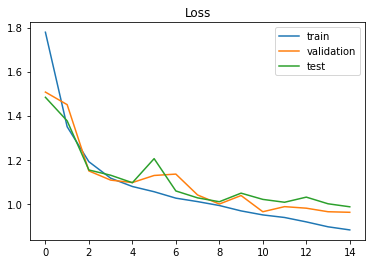

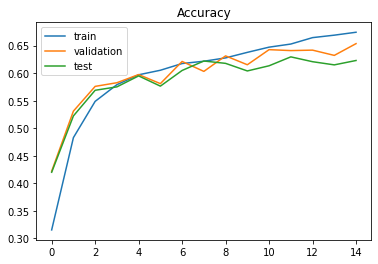

In [44]:
random.seed(seed)
torch.manual_seed(seed)

net = MyCNN_6_1_L()
optimizer = optim.Adam(net.parameters(), lr = 0.0005, weight_decay=0.001)
l6_models, l6_results = train(net, loaders, optimizer, criterion, device=device)


In [45]:
results = pd.DataFrame(l6_results).transpose()
max_score = np.amax(results[["validation_accuracy"]], axis=0)
best_score = results[results["validation_accuracy"]==max_score[0]]
best_score

,train_loss,train_accuracy,validation_loss,validation_accuracy,test_loss,test_accuracy
15,0.881208,0.674247,0.96119,0.653564,0.98617,0.622971


## +1 Conv

In [46]:
class MyCNN_6_1_L_1_Ablation(nn.Module): 
  #Constructor
  def __init__(self, in_size=3, out_size=7, use_norm=False):
    # Call parent contructor
    super().__init__()
    self.conv_layers = nn.Sequential(
      # Layer 1
      nn.Conv2d(in_channels=in_size, out_channels=64, kernel_size=3, padding=1, stride=1),
      nn.ReLU(),
      nn.BatchNorm2d(64),
      # Layer 2
      nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1, stride=1),
      nn.ReLU(),
      nn.BatchNorm2d(128),
      nn.MaxPool2d(kernel_size=2, stride=2),
      # Layer 3
      nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1, stride=1),
      nn.ReLU(),
      nn.BatchNorm2d(256),
      nn.MaxPool2d(kernel_size=2, stride=2),
      nn.Dropout(0.25),
      # Layer 4
      nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1, stride=1),
      nn.ReLU(),
      nn.BatchNorm2d(512),
      nn.MaxPool2d(kernel_size=2, stride=2),
      nn.Dropout(0.25),
      # Layer 5
      nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, padding=1, stride=1),
      nn.ReLU(),
      nn.BatchNorm2d(1024),
      nn.MaxPool2d(kernel_size=2, stride=2),
      nn.Dropout(0.25),
      # Layer 6
      nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, padding=1, stride=1),
      nn.ReLU(),
      nn.BatchNorm2d(1024),
      nn.AdaptiveMaxPool2d(output_size=2),
    )
    self.fc_layers = nn.Sequential(
      nn.Linear(4096, 1024),
      nn.ReLU(),
      nn.BatchNorm1d(1024),    
      nn.Dropout(0.5),
      nn.Linear(1024, out_size),
    )
  # Forward
  def forward(self, x):
    b, _, _, _ = x.shape
    x = self.conv_layers(x)
    x = x.view(x.size(0), -1) 
    #print(x.size()) 
    output = self.fc_layers(x)
    return output.view(b, -1)


Running epoch: 1
Epoch 1: TrL=1.7390, TrA=0.3292, VaL=2.0868, VaA=0.4103, TeL=1.9383, TeA=0.4196,
Running epoch: 2
Epoch 2: TrL=1.4011, TrA=0.4650, VaL=1.4593, VaA=0.4999, TeL=1.2960, TeA=0.5002,
Running epoch: 3
Epoch 3: TrL=1.2555, TrA=0.5217, VaL=1.3095, VaA=0.5229, TeL=1.7490, TeA=0.5333,
Running epoch: 4
Epoch 4: TrL=1.1612, TrA=0.5566, VaL=1.1761, VaA=0.5640, TeL=1.1887, TeA=0.5700,
Running epoch: 5
Epoch 5: TrL=1.1014, TrA=0.5844, VaL=1.1155, VaA=0.5878, TeL=1.1359, TeA=0.5745,
Running epoch: 6
Epoch 6: TrL=1.0548, TrA=0.6042, VaL=1.0706, VaA=0.5952, TeL=1.1076, TeA=0.5940,
Running epoch: 7
Epoch 7: TrL=1.0203, TrA=0.6189, VaL=1.0414, VaA=0.6259, TeL=1.1981, TeA=0.6130,
Running epoch: 8
Epoch 8: TrL=0.9989, TrA=0.6287, VaL=1.0391, VaA=0.6183, TeL=1.0804, TeA=0.6057,
Running epoch: 9
Epoch 9: TrL=0.9862, TrA=0.6296, VaL=1.0174, VaA=0.6163, TeL=1.0358, TeA=0.6043,
Running epoch: 10
Epoch 10: TrL=0.9656, TrA=0.6409, VaL=0.9826, VaA=0.6363, TeL=1.0040, TeA=0.6196,
Running epoch: 11


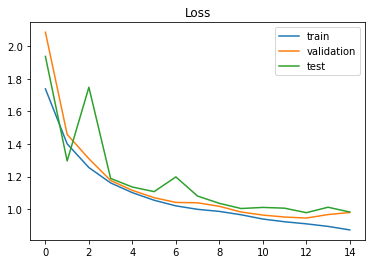

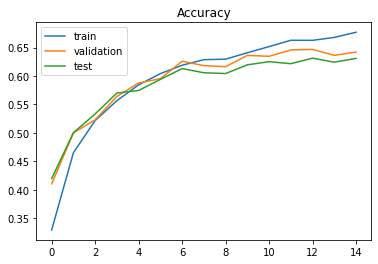

In [47]:
random.seed(seed)
torch.manual_seed(seed)

net = MyCNN_6_1_L_1_Ablation()
optimizer = optim.Adam(net.parameters(), lr = 0.0005, weight_decay=0.001)
l6_models_1, l6_results_1 = train(net, loaders, optimizer, criterion, device=device)

In [48]:
results = pd.DataFrame(l6_results_1).transpose()
max_score = np.amax(results[["validation_accuracy"]], axis=0)
best_score = results[results["validation_accuracy"]==max_score[0]]
best_score

,train_loss,train_accuracy,validation_loss,validation_accuracy,test_loss,test_accuracy
13,0.909853,0.662702,0.945406,0.646765,0.978338,0.631414


## +1 FC

In [49]:
class MyCNN_6_1_2_Ablation(nn.Module): #62 epochs 2h 35m
  #Constructor
  def __init__(self, in_size=3, out_size=7, use_norm=False):
    # Call parent contructor
    super().__init__()
    self.conv_layers = nn.Sequential(
      # Layer 1
      nn.Conv2d(in_channels=in_size, out_channels=64, kernel_size=3, padding=1, stride=1),
      nn.ReLU(),
      nn.BatchNorm2d(64),
      # Layer 2
      nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1, stride=1),
      nn.ReLU(),
      nn.BatchNorm2d(128),
      nn.MaxPool2d(kernel_size=2, stride=2),
      # Layer 3
      nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1, stride=1),
      nn.ReLU(),
      nn.BatchNorm2d(256),
      nn.MaxPool2d(kernel_size=2, stride=2),
      nn.Dropout(0.25),
      # Layer 4
      nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1, stride=1),
      nn.ReLU(),
      nn.BatchNorm2d(512),
      nn.MaxPool2d(kernel_size=2, stride=2),
      nn.Dropout(0.25),
      # Layer 6
      nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, padding=1, stride=1),
      nn.ReLU(),
      nn.BatchNorm2d(1024),
      nn.AdaptiveMaxPool2d(output_size=2),
    )
    self.fc_layers = nn.Sequential(
      nn.Linear(4096, 1024),
      nn.ReLU(),
      nn.BatchNorm1d(1024),
      nn.Linear(1024, 512),
      nn.ReLU(),
      nn.BatchNorm1d(512),      
      nn.Dropout(0.5),
      nn.Linear(512, out_size),
    )
  # Forward
  def forward(self, x):
    b, _, _, _ = x.shape
    x = self.conv_layers(x)
    x = x.view(x.size(0), -1) 
    #print(x.size()) 
    output = self.fc_layers(x)
    return output.view(b, -1)


Running epoch: 1
Epoch 1: TrL=1.6620, TrA=0.3704, VaL=1.4645, VaA=0.4705, TeL=1.4509, TeA=0.4685,
Running epoch: 2
Epoch 2: TrL=1.2679, TrA=0.5183, VaL=1.1916, VaA=0.5380, TeL=1.1954, TeA=0.5505,
Running epoch: 3
Epoch 3: TrL=1.1410, TrA=0.5705, VaL=1.1352, VaA=0.5837, TeL=1.2126, TeA=0.5760,
Running epoch: 4
Epoch 4: TrL=1.0828, TrA=0.5914, VaL=1.0778, VaA=0.5930, TeL=1.0777, TeA=0.5936,
Running epoch: 5
Epoch 5: TrL=1.0380, TrA=0.6127, VaL=1.0339, VaA=0.6040, TeL=1.1086, TeA=0.5925,
Running epoch: 6
Epoch 6: TrL=1.0103, TrA=0.6212, VaL=1.0011, VaA=0.6251, TeL=1.0496, TeA=0.5967,
Running epoch: 7
Epoch 7: TrL=0.9813, TrA=0.6338, VaL=1.0562, VaA=0.6155, TeL=1.1136, TeA=0.6120,
Running epoch: 8
Epoch 8: TrL=0.9585, TrA=0.6435, VaL=0.9964, VaA=0.6212, TeL=1.0397, TeA=0.6041,
Running epoch: 9
Epoch 9: TrL=0.9315, TrA=0.6526, VaL=1.0008, VaA=0.6300, TeL=1.0546, TeA=0.6196,
Running epoch: 10
Epoch 10: TrL=0.9067, TrA=0.6599, VaL=0.9702, VaA=0.6434, TeL=1.0088, TeA=0.6221,
Running epoch: 11


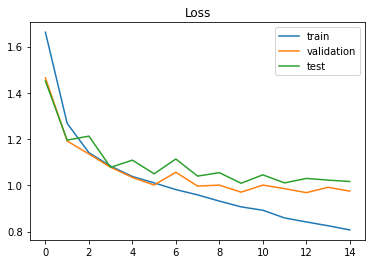

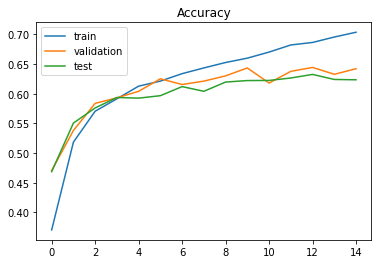

In [50]:
random.seed(seed)
torch.manual_seed(seed)

net = MyCNN_6_1_2_Ablation()
optimizer = optim.Adam(net.parameters(), lr = 0.0005, weight_decay=0.001)
l6_models_2, l6_results_2 = train(net, loaders, optimizer, criterion, device=device)

In [51]:
results = pd.DataFrame(l6_results_2).transpose()
max_score = np.amax(results[["validation_accuracy"]], axis=0)
best_score = results[results["validation_accuracy"]==max_score[0]]
best_score

,train_loss,train_accuracy,validation_loss,validation_accuracy,test_loss,test_accuracy
13,0.841363,0.686384,0.968121,0.644298,1.029582,0.632511


## Chosen Model

In [52]:
class ChosenModel(nn.Module):
  def __init__(self, in_size=3, out_size=7):
    super().__init__()
    self.conv_layers = nn.Sequential(
      # Layer 1
      nn.Conv2d(in_channels=in_size, out_channels=64, kernel_size=3, padding=1, stride=1),
      nn.ReLU(),
      nn.BatchNorm2d(64),
      # Layer 2
      nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1, stride=1),
      nn.ReLU(),
      nn.BatchNorm2d(128),
      nn.MaxPool2d(kernel_size=2, stride=2),
      # Layer 3
      nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1, stride=1),
      nn.ReLU(),
      nn.BatchNorm2d(256),
      nn.MaxPool2d(kernel_size=2, stride=2),
      nn.Dropout(0.25),
      # Layer 4
      nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1, stride=1),
      nn.ReLU(),
      nn.BatchNorm2d(512),
      nn.MaxPool2d(kernel_size=2, stride=2),
      nn.Dropout(0.25),
      # Layer 6
      nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, padding=1, stride=1),
      nn.ReLU(),
      nn.BatchNorm2d(1024),
      nn.AdaptiveMaxPool2d(output_size=2),
    )
    self.fc_layers = nn.Sequential(
      nn.Linear(4096, 1024),
      nn.ReLU(),
      nn.BatchNorm1d(1024),
      nn.Linear(1024, out_size),
    )
  # Forward
  def forward(self, x):
    b, _, _, _ = x.shape
    x = self.conv_layers(x)
    x = x.view(x.size(0), -1) 
    #print(x.size()) 
    output = self.fc_layers(x)
    return output.view(b, -1)


Running epoch: 1
Epoch 1: TrL=1.5247, TrA=0.4172, VaL=1.3080, VaA=0.4928, TeL=1.3430, TeA=0.4854,
Running epoch: 2
Epoch 2: TrL=1.2761, TrA=0.5158, VaL=1.1835, VaA=0.5530, TeL=1.1961, TeA=0.5429,
Running epoch: 3
Epoch 3: TrL=1.1468, TrA=0.5678, VaL=1.1010, VaA=0.5867, TeL=1.1340, TeA=0.5747,
Running epoch: 4
Epoch 4: TrL=1.0799, TrA=0.5926, VaL=1.0722, VaA=0.5991, TeL=1.0801, TeA=0.5896,
Running epoch: 5
Epoch 5: TrL=1.0263, TrA=0.6142, VaL=1.0310, VaA=0.6052, TeL=1.0501, TeA=0.6156,
Running epoch: 6
Epoch 6: TrL=0.9965, TrA=0.6262, VaL=1.0234, VaA=0.6158, TeL=1.0511, TeA=0.6081,
Running epoch: 7
Epoch 7: TrL=0.9648, TrA=0.6397, VaL=1.0205, VaA=0.6213, TeL=1.0430, TeA=0.6109,
Running epoch: 8
Epoch 8: TrL=0.9366, TrA=0.6492, VaL=0.9935, VaA=0.6275, TeL=1.0353, TeA=0.6180,
Running epoch: 9
Epoch 9: TrL=0.9137, TrA=0.6608, VaL=0.9814, VaA=0.6345, TeL=1.0014, TeA=0.6338,
Running epoch: 10
Epoch 10: TrL=0.8855, TrA=0.6712, VaL=0.9940, VaA=0.6229, TeL=0.9890, TeA=0.6358,
Running epoch: 11


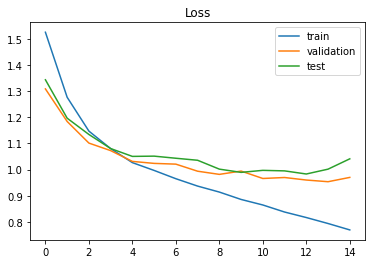

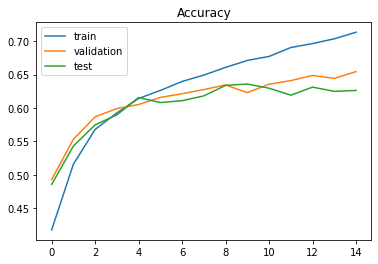

In [53]:
random.seed(seed)
torch.manual_seed(seed)

net = ChosenModel()
optimizer = optim.Adam(net.parameters(), lr = 0.0005, weight_decay=0.001)
l6_models_3, l6_results_3 = train(net, loaders, optimizer, criterion, device=device)

In [54]:
summary(net.to(device),(3,48,48))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 48, 48]           1,792
              ReLU-2           [-1, 64, 48, 48]               0
       BatchNorm2d-3           [-1, 64, 48, 48]             128
            Conv2d-4          [-1, 128, 48, 48]          73,856
              ReLU-5          [-1, 128, 48, 48]               0
       BatchNorm2d-6          [-1, 128, 48, 48]             256
         MaxPool2d-7          [-1, 128, 24, 24]               0
            Conv2d-8          [-1, 256, 24, 24]         295,168
              ReLU-9          [-1, 256, 24, 24]               0
      BatchNorm2d-10          [-1, 256, 24, 24]             512
        MaxPool2d-11          [-1, 256, 12, 12]               0
          Dropout-12          [-1, 256, 12, 12]               0
           Conv2d-13          [-1, 512, 12, 12]       1,180,160
             ReLU-14          [-1, 512,

In [55]:
results = pd.DataFrame(l6_results_3).transpose()
max_score = np.amax(results[["validation_accuracy"]], axis=0)
best_score = results[results["validation_accuracy"]==max_score[0]]
best_score

,train_loss,train_accuracy,validation_loss,validation_accuracy,test_loss,test_accuracy
15,0.769055,0.713414,0.969787,0.654386,1.040814,0.626206


## -1 Conv

In [56]:
class MyCNN_6_1_4_Ablation(nn.Module): #62 epochs 2h 35m
  #Constructor
  def __init__(self, in_size=3, out_size=7, use_norm=False):
    # Call parent contructor
    super().__init__()
    self.conv_layers = nn.Sequential(
      # Layer 1
      nn.Conv2d(in_channels=in_size, out_channels=64, kernel_size=3, padding=1, stride=1),
      nn.ReLU(),
      nn.BatchNorm2d(64),
      # Layer 2
      nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1, stride=1),
      nn.ReLU(),
      nn.BatchNorm2d(128),
      nn.MaxPool2d(kernel_size=2, stride=2),
      # Layer 3
      nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1, stride=1),
      nn.ReLU(),
      nn.BatchNorm2d(256),
      nn.MaxPool2d(kernel_size=2, stride=2),
      nn.Dropout(0.25),
      # Layer 6
      nn.Conv2d(in_channels=256, out_channels=1024, kernel_size=3, padding=1, stride=1),
      nn.ReLU(),
      nn.BatchNorm2d(1024),
      nn.AdaptiveMaxPool2d(output_size=2),
    )
    self.fc_layers = nn.Sequential(
      nn.Linear(4096, 1024),
      nn.ReLU(),
      nn.BatchNorm1d(1024),
      nn.Linear(1024, out_size),
    )
  # Forward
  def forward(self, x):
    b, _, _, _ = x.shape
    x = self.conv_layers(x)
    x = x.view(x.size(0), -1) 
    #print(x.size()) 
    output = self.fc_layers(x)
    return output.view(b, -1)


Running epoch: 1
Epoch 1: TrL=1.4363, TrA=0.4541, VaL=1.1949, VaA=0.5577, TeL=1.2235, TeA=0.5376,
Running epoch: 2
Epoch 2: TrL=1.1684, TrA=0.5622, VaL=1.1488, VaA=0.5645, TeL=1.2021, TeA=0.5501,
Running epoch: 3
Epoch 3: TrL=1.0821, TrA=0.5918, VaL=1.0774, VaA=0.6040, TeL=1.1047, TeA=0.5851,
Running epoch: 4
Epoch 4: TrL=1.0310, TrA=0.6145, VaL=1.1656, VaA=0.5536, TeL=1.1984, TeA=0.5451,
Running epoch: 5
Epoch 5: TrL=0.9888, TrA=0.6322, VaL=1.0960, VaA=0.5772, TeL=1.0957, TeA=0.5812,
Running epoch: 6
Epoch 6: TrL=0.9631, TrA=0.6438, VaL=1.0379, VaA=0.6130, TeL=1.0613, TeA=0.6078,
Running epoch: 7
Epoch 7: TrL=0.9290, TrA=0.6550, VaL=1.0724, VaA=0.6040, TeL=1.0912, TeA=0.6004,
Running epoch: 8
Epoch 8: TrL=0.8952, TrA=0.6654, VaL=1.0854, VaA=0.6122, TeL=1.0730, TeA=0.6120,
Running epoch: 9
Epoch 9: TrL=0.8620, TrA=0.6848, VaL=1.0605, VaA=0.6141, TeL=1.0658, TeA=0.6103,
Running epoch: 10
Epoch 10: TrL=0.8462, TrA=0.6863, VaL=1.0328, VaA=0.6325, TeL=1.0697, TeA=0.6016,
Running epoch: 11


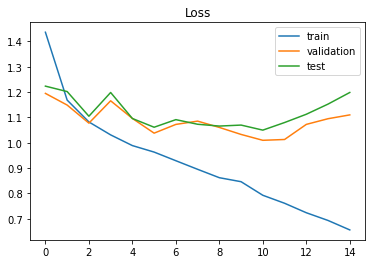

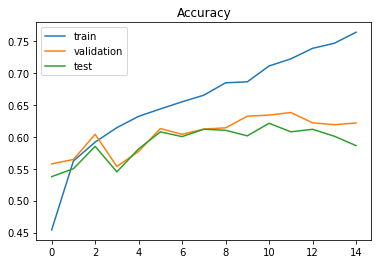

In [57]:
random.seed(seed)
torch.manual_seed(seed)

net = MyCNN_6_1_4_Ablation()
optimizer = optim.Adam(net.parameters(), lr = 0.0005, weight_decay=0.001)
l6_models_4, l6_results_4 = train(net, loaders, optimizer, criterion, device=device)

In [58]:
results = pd.DataFrame(l6_results_4).transpose()
max_score = np.amax(results[["validation_accuracy"]], axis=0)
best_score = results[results["validation_accuracy"]==max_score[0]]
best_score

,train_loss,train_accuracy,validation_loss,validation_accuracy,test_loss,test_accuracy
12,0.761103,0.722342,1.012828,0.638213,1.079783,0.607895


## -2 Conv

In [59]:
class MyCNN_6_1_5_Ablation(nn.Module): #62 epochs 2h 35m
  #Constructor
  def __init__(self, in_size=3, out_size=7, use_norm=False):
    # Call parent contructor
    super().__init__()
    self.conv_layers = nn.Sequential(
      # Layer 1
      nn.Conv2d(in_channels=in_size, out_channels=64, kernel_size=3, padding=1, stride=1),
      nn.ReLU(),
      nn.BatchNorm2d(64),
      # Layer 2
      nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1, stride=1),
      nn.ReLU(),
      nn.BatchNorm2d(128),
      nn.MaxPool2d(kernel_size=2, stride=2),
      # Layer 6
      nn.Conv2d(in_channels=128, out_channels=1024, kernel_size=3, padding=1, stride=1),
      nn.ReLU(),
      nn.BatchNorm2d(1024),
      nn.AdaptiveMaxPool2d(output_size=2),
    )
    self.fc_layers = nn.Sequential(
      nn.Linear(4096, 1024),
      nn.ReLU(),
      nn.BatchNorm1d(1024),
      nn.Linear(1024, out_size),
    )
  # Forward
  def forward(self, x):
    b, _, _, _ = x.shape
    x = self.conv_layers(x)
    x = x.view(x.size(0), -1) 
    #print(x.size()) 
    output = self.fc_layers(x)
    return output.view(b, -1)


Running epoch: 1
Epoch 1: TrL=1.4532, TrA=0.4459, VaL=1.3008, VaA=0.5075, TeL=1.2987, TeA=0.5130,
Running epoch: 2
Epoch 2: TrL=1.1992, TrA=0.5478, VaL=1.3076, VaA=0.4974, TeL=1.3114, TeA=0.4939,
Running epoch: 3
Epoch 3: TrL=1.1125, TrA=0.5837, VaL=1.1380, VaA=0.5782, TeL=1.1919, TeA=0.5495,
Running epoch: 4
Epoch 4: TrL=1.0585, TrA=0.6047, VaL=1.1871, VaA=0.5522, TeL=1.2221, TeA=0.5450,
Running epoch: 5
Epoch 5: TrL=1.0119, TrA=0.6233, VaL=1.2082, VaA=0.5488, TeL=1.2475, TeA=0.5257,
Running epoch: 6
Epoch 6: TrL=0.9652, TrA=0.6438, VaL=1.5890, VaA=0.4556, TeL=1.6515, TeA=0.4506,
Running epoch: 7
Epoch 7: TrL=0.9180, TrA=0.6652, VaL=1.2699, VaA=0.5533, TeL=1.2992, TeA=0.5355,
Running epoch: 8
Epoch 8: TrL=0.8700, TrA=0.6828, VaL=1.4116, VaA=0.4976, TeL=1.4993, TeA=0.4728,
Running epoch: 9
Epoch 9: TrL=0.8188, TrA=0.7062, VaL=1.3797, VaA=0.5197, TeL=1.4000, TeA=0.5245,
Running epoch: 10
Epoch 10: TrL=0.7547, TrA=0.7309, VaL=1.1644, VaA=0.6012, TeL=1.1683, TeA=0.5897,
Running epoch: 11


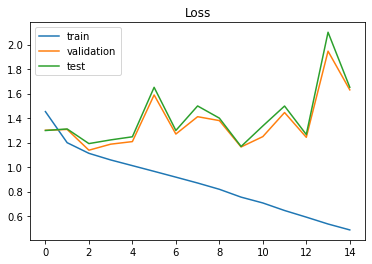

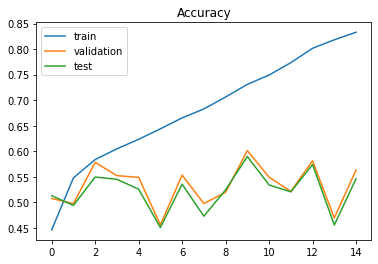

In [60]:
random.seed(seed)
torch.manual_seed(seed)

net = MyCNN_6_1_5_Ablation()
optimizer = optim.Adam(net.parameters(), lr = 0.0005, weight_decay=0.001)
l6_models_5, l6_results_5 = train(net, loaders, optimizer, criterion, device=device)

In [61]:
results = pd.DataFrame(l6_results_5).transpose()
max_score = np.amax(results[["validation_accuracy"]], axis=0)
best_score = results[results["validation_accuracy"]==max_score[0]]
best_score

,train_loss,train_accuracy,validation_loss,validation_accuracy,test_loss,test_accuracy
10,0.754668,0.730852,1.16444,0.601206,1.16834,0.589693


## -3 Conv

In [62]:
class MyCNN_6_1_6_Ablation(nn.Module): #62 epochs 2h 35m
  #Constructor
  def __init__(self, in_size=3, out_size=7, use_norm=False):
    # Call parent contructor
    super().__init__()
    self.conv_layers = nn.Sequential(
      # Layer 1
      nn.Conv2d(in_channels=in_size, out_channels=64, kernel_size=3, padding=1, stride=1),
      nn.ReLU(),
      nn.BatchNorm2d(64),
      # Layer 6
      nn.Conv2d(in_channels=64, out_channels=1024, kernel_size=3, padding=1, stride=1),
      nn.ReLU(),
      nn.BatchNorm2d(1024),
      nn.AdaptiveMaxPool2d(output_size=2),
    )
    self.fc_layers = nn.Sequential(
      nn.Linear(4096, 1024),
      nn.ReLU(),
      nn.BatchNorm1d(1024),
      nn.Linear(1024, out_size),
    )
  # Forward
  def forward(self, x):
    b, _, _, _ = x.shape
    x = self.conv_layers(x)
    x = x.view(x.size(0), -1) 
    #print(x.size()) 
    output = self.fc_layers(x)
    return output.view(b, -1)


Running epoch: 1
Epoch 1: TrL=1.5526, TrA=0.4016, VaL=1.4678, VaA=0.4308, TeL=1.4948, TeA=0.4251,
Running epoch: 2
Epoch 2: TrL=1.3538, TrA=0.4836, VaL=1.4480, VaA=0.4774, TeL=1.4440, TeA=0.4809,
Running epoch: 3
Epoch 3: TrL=1.2795, TrA=0.5167, VaL=1.5145, VaA=0.4332, TeL=1.5332, TeA=0.4152,
Running epoch: 4
Epoch 4: TrL=1.2494, TrA=0.5315, VaL=1.4989, VaA=0.4297, TeL=1.4905, TeA=0.4300,
Running epoch: 5
Epoch 5: TrL=1.2101, TrA=0.5477, VaL=1.2684, VaA=0.5218, TeL=1.3378, TeA=0.5035,
Running epoch: 6
Epoch 6: TrL=1.1711, TrA=0.5623, VaL=1.3749, VaA=0.4809, TeL=1.4383, TeA=0.4602,
Running epoch: 7
Epoch 7: TrL=1.1469, TrA=0.5701, VaL=1.2349, VaA=0.5267, TeL=1.2596, TeA=0.5202,
Running epoch: 8
Epoch 8: TrL=1.1173, TrA=0.5835, VaL=1.1958, VaA=0.5544, TeL=1.2230, TeA=0.5385,
Running epoch: 9
Epoch 9: TrL=1.0953, TrA=0.5903, VaL=1.2000, VaA=0.5530, TeL=1.2281, TeA=0.5348,
Running epoch: 10
Epoch 10: TrL=1.0811, TrA=0.5913, VaL=1.2118, VaA=0.5530, TeL=1.2405, TeA=0.5342,
Running epoch: 11


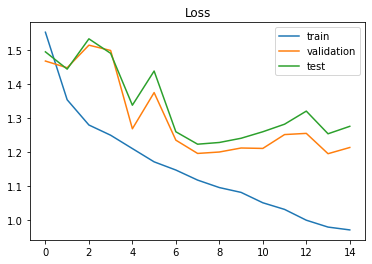

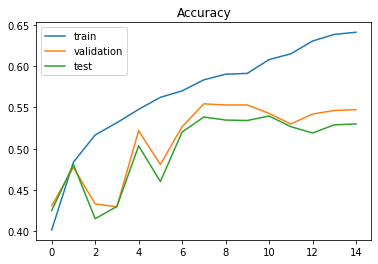

In [63]:
random.seed(seed)
torch.manual_seed(seed)


net = MyCNN_6_1_6_Ablation()
optimizer = optim.Adam(net.parameters(), lr = 0.0005, weight_decay=0.001)
l6_models_6, l6_results_6 = train(net, loaders, optimizer, criterion, device=device)

In [64]:
results = pd.DataFrame(l6_results_6).transpose()
max_score = np.amax(results[["validation_accuracy"]], axis=0)
best_score = results[results["validation_accuracy"]==max_score[0]]
best_score

,train_loss,train_accuracy,validation_loss,validation_accuracy,test_loss,test_accuracy
8,1.117334,0.583496,1.1958,0.554386,1.223002,0.538487


## -4 Conv

In [65]:
class MyCNN_6_1_7_Ablation(nn.Module): #62 epochs 2h 35m
  #Constructor
  def __init__(self, in_size=3, out_size=7, use_norm=False):
    # Call parent contructor
    super().__init__()
    self.conv_layers = nn.Sequential(
      # Layer 1
      nn.Conv2d(in_channels=in_size, out_channels=64, kernel_size=3, padding=1, stride=1),
      nn.ReLU(),
      nn.BatchNorm2d(64),
    )
    self.fc_layers = nn.Sequential(
      nn.Linear(147456, 1024),
      nn.ReLU(),
      nn.BatchNorm1d(1024),
      nn.Linear(1024, out_size),
    )
  # Forward
  def forward(self, x):
    b, _, _, _ = x.shape
    x = self.conv_layers(x)
    x = x.view(x.size(0), -1) 
    #print(x.size()) 
    output = self.fc_layers(x)
    return output.view(b, -1)


Running epoch: 1
Epoch 1: TrL=1.7287, TrA=0.3428, VaL=1.5761, VaA=0.3765, TeL=1.5836, TeA=0.3686,
Running epoch: 2
Epoch 2: TrL=1.5504, TrA=0.3990, VaL=1.5131, VaA=0.4012, TeL=1.5235, TeA=0.3946,
Running epoch: 3
Epoch 3: TrL=1.4832, TrA=0.4291, VaL=1.4880, VaA=0.4286, TeL=1.4937, TeA=0.4207,
Running epoch: 4
Epoch 4: TrL=1.4328, TrA=0.4480, VaL=1.4324, VaA=0.4446, TeL=1.4234, TeA=0.4500,
Running epoch: 5
Epoch 5: TrL=1.3842, TrA=0.4700, VaL=1.4219, VaA=0.4519, TeL=1.4177, TeA=0.4538,
Running epoch: 6
Epoch 6: TrL=1.3233, TrA=0.4935, VaL=1.4199, VaA=0.4617, TeL=1.4180, TeA=0.4542,
Running epoch: 7
Epoch 7: TrL=1.2741, TrA=0.5195, VaL=1.3808, VaA=0.4727, TeL=1.3885, TeA=0.4714,
Running epoch: 8
Epoch 8: TrL=1.1992, TrA=0.5565, VaL=1.3798, VaA=0.4664, TeL=1.3776, TeA=0.4686,
Running epoch: 9
Epoch 9: TrL=1.1080, TrA=0.5942, VaL=1.3769, VaA=0.4672, TeL=1.4009, TeA=0.4671,
Running epoch: 10
Epoch 10: TrL=1.0251, TrA=0.6345, VaL=1.3742, VaA=0.4897, TeL=1.4281, TeA=0.4621,
Running epoch: 11


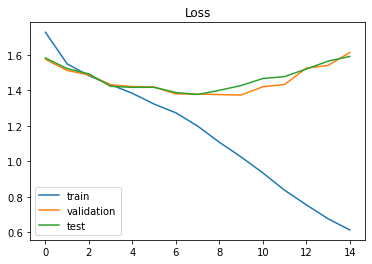

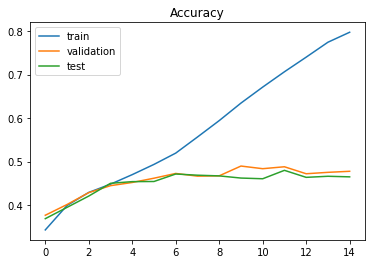

In [66]:
random.seed(seed)
torch.manual_seed(seed)

net = MyCNN_6_1_7_Ablation()
optimizer = optim.Adam(net.parameters(), lr = 0.0005, weight_decay=0.001)
l6_models_7, l6_results_7 = train(net, loaders, optimizer, criterion, device=device)

In [67]:
results = pd.DataFrame(l6_results_7).transpose()
max_score = np.amax(results[["validation_accuracy"]], axis=0)
best_score = results[results["validation_accuracy"]==max_score[0]]
best_score

,train_loss,train_accuracy,validation_loss,validation_accuracy,test_loss,test_accuracy
10,1.025124,0.634521,1.374201,0.489693,1.428054,0.462061


# Best Model Evaluation

In [68]:
best_model = l6_models_3[15].to(device).eval()

In [69]:
def predict_image(img, model):
    img = (img.unsqueeze(dim=0)).to(device)
    yb = model(img)
    _, preds  = torch.max(yb, dim=1)
    return emotion_label_to_text[preds[0].item()]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: anger , Predicted: neutral


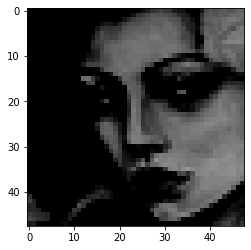

In [70]:
img, label = test_dset[7]
plt.imshow(img.permute(1, 2, 0))
print('Label:', emotion_label_to_text[label.item()], ', Predicted:', predict_image(img, best_model))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: anger , Predicted: anger


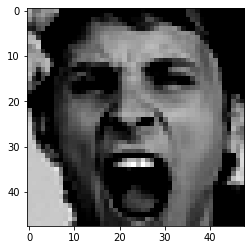

In [71]:
img, label = test_dset[11]
plt.imshow(img.permute(1, 2, 0))
print('Label:', emotion_label_to_text[label.item()], ', Predicted:', predict_image(img, best_model))

# Confusion Matrix

In [72]:
predictions, targets = [], []
for images, labels in test_loader:
    predict = best_model(images.to(device))
    _, y  = torch.max(predict, dim=1)

    preds = y.detach().cpu().numpy()
    labels = labels.detach().cpu().numpy()
    
    for i in range(len(preds)):
        predictions.append(preds[i])
        targets.append(labels[i])

Text(60.0, 0.5, 'True Labels')

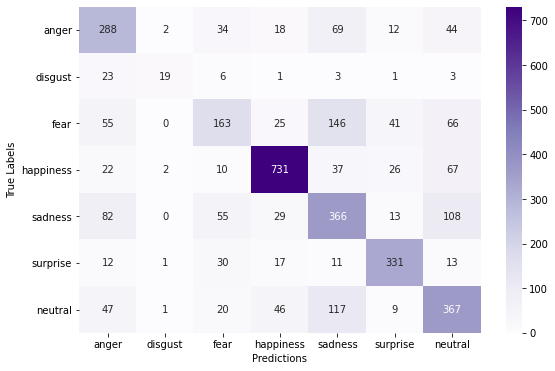

In [85]:
cm = confusion_matrix(targets, predictions)
df_cm = pd.DataFrame(cm, emotion_label_to_text.values(), emotion_label_to_text.values())
plt.figure(figsize = (9,6))
sns.heatmap(df_cm, annot=True, fmt="d", cmap='Purples')
plt.xlabel("Predictions")
plt.ylabel("True Labels")

In [74]:
report_test_nn = classification_report(targets, predictions, target_names= emotion_label_to_text.values())
print(report_test_nn)

              precision    recall  f1-score   support

       anger       0.54      0.62      0.58       467
     disgust       0.76      0.34      0.47        56
        fear       0.51      0.33      0.40       496
   happiness       0.84      0.82      0.83       895
     sadness       0.49      0.56      0.52       653
    surprise       0.76      0.80      0.78       415
     neutral       0.55      0.60      0.58       607

    accuracy                           0.63      3589
   macro avg       0.64      0.58      0.59      3589
weighted avg       0.63      0.63      0.63      3589



In [75]:
torch.save(l6_models_3[15].state_dict(), "chosen_model.pt")
torch.save(l6_models[15].state_dict(), "complete_model.pt")